In [27]:
from os.path import join
import json
from collections import defaultdict
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

procs = [f'proc{i}' for i in range(1, 7)]
proc2tasks = {}

for proc in procs:
    for prefix, info in prefix2file.items():
        if info.get('procedure', None) == proc:
            task_id = info['task']['task_id']
            duration = info['task']['duration']
            if proc == 'proc1':
                tl = info['task']['translator']
                if tl == 'deepl_document':
                    key = f'proc1-deepl'
                else:
                    key = f'proc1-gpt'
            else:
                key = proc
            if key not in proc2tasks:
                proc2tasks[key] = {}
            if task_id not in proc2tasks[key]:
                proc2tasks[key][task_id] = duration

In [28]:
for k, v in proc2tasks.items():
    num_tasks = len(v)
    total_minutes = sum(v.values()) / 60
    label = f'{k} ({num_tasks})'
    print(f"{label:<15} {total_minutes:>10.1f} min")

proc1-deepl (3)        8.8 min
proc1-gpt (3)        156.1 min
proc2 (1)            245.0 min
proc3 (5)            408.0 min
proc4 (10)           310.0 min
proc5 (2)             49.8 min
proc6 (2)             38.6 min


In [29]:
from os.path import join
import json
from collections import defaultdict
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

procs = [f'proc{i}' for i in range(1, 7)]

total_time = defaultdict(int)

for proc in procs:
    for prefix, info in prefix2file.items():
        if info.get('procedure', None) == proc:
            duration = info['log']['end'] - info['log']['start']
            if proc == 'proc1':
                tl = info['task']['translator']
                if tl == 'deepl_document':
                    key = f'proc1-deepl'
                else:
                    key = f'proc1-gpt'
            else:
                key = proc
            total_time[key] += duration

In [30]:
for k, v in total_time.items():
    total_minutes = v / 60
    label = f'{k}'
    print(f"{label:<15} {total_minutes:>10.1f} min")

proc1-deepl            8.6 min
proc1-gpt            145.9 min
proc2                163.3 min
proc3                166.4 min
proc4                272.4 min
proc5                 17.1 min
proc6                 37.8 min


In [31]:
print(f'DeepL: {(total_time['proc1-deepl']+total_time['proc6'])/60:.2f}min')
print(f'GPT4.1: {(total_time['proc1-gpt'
                             ]+total_time['proc2']+total_time['proc3']+total_time['proc4'])/60:.2f}min')

DeepL: 46.48min
GPT4.1: 748.00min


In [32]:
from os.path import join
import pandas as pd
import json

time2df = {}

parts = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']

with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

for part in parts:
    data = {'Label': [], 'Time': [], 'Out_Tokens': [],
            'In_Tokens': [], 'Chars': []}
    for prefix, info in prefix2file.items():
        if prefix.startswith(part):
            src_lang, tgt_lang = prefix.split('-')[2], prefix.split('-')[3]
            duration = info['log']['end'] - info['log']['start']
            data['Label'].append(f'{src_lang}-{tgt_lang}')
            data['Time'].append(duration)
            data['Chars'].append(info['log']['in_chars'])
            if part.endswith('gpt'):
                data['Out_Tokens'].append(info['log']['out_model_tokens'])
                data['In_Tokens'].append(info['log']['in_model_tokens'])
            if part.endswith('deepl'):
                data['In_Tokens'].append(info['log']['out_tokens'])
                data['Out_Tokens'].append(info['log']['in_tokens'])

    df = pd.DataFrame(data)
    time2df[part] = df

In [33]:
time2df['ep-gpt'].head(3)

,Label,Time,Out_Tokens,In_Tokens,Chars
0,da-en,142.0,11630,16023,59666
1,de-en,252.0,11335,14145,66315
2,el-en,240.0,12790,24600,72275


In [34]:
import pandas as pd
for k in time2df:
    dataset, translator = k.split('-')
    time2df[k]['dataset'] = dataset
    time2df[k]['translator'] = translator
    split_langs = time2df[k]['Label'].str.split('-', expand=True)
    time2df[k]['src_lang'] = split_langs[0]
    time2df[k]['tgt_lang'] = split_langs[1]
    time2df[k].drop(columns=['Label'], inplace=True)

time_df = pd.concat(time2df.values(), ignore_index=True)
print(len(time_df))
time_df.head(3)

480


,Time,Out_Tokens,In_Tokens,Chars,dataset,translator,src_lang,tgt_lang
0,142.0,11630,16023,59666,ep,gpt,da,en
1,252.0,11335,14145,66315,ep,gpt,de,en
2,240.0,12790,24600,72275,ep,gpt,el,en


In [35]:
import pandas as pd
df = pd.read_csv('final_results.csv')
print(len(df))
df.head(3)

480


,BLEU,chrF,BERT-F1,dataset,translator,src_lang,tgt_lang,COMET
0,54.799530,75.295543,93.870700,flores,deepl,da,en,91.044375
1,33.634741,60.229124,89.559616,flores,deepl,fr,pt,88.003590
2,28.786491,57.433125,86.359790,flores,gpt,nl,de,86.766763


In [36]:
df = pd.merge(df, time_df, on=['dataset', 'translator', 'src_lang', 'tgt_lang'])
print(len(df))
df.head(3)

480


,BLEU,chrF,BERT-F1,dataset,translator,src_lang,tgt_lang,COMET,Time,Out_Tokens,In_Tokens,Chars
0,54.799530,75.295543,93.870700,flores,deepl,da,en,91.044375,10.874540,14097,10227,50961
1,33.634741,60.229124,89.559616,flores,deepl,fr,pt,88.003590,11.132139,13914,12544,58255
2,28.786491,57.433125,86.359790,flores,gpt,nl,de,86.766763,145.805712,12997,12808,55471


# Time Analysis GPT

Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['gpt'] : ['gpt']
Metric: Out_Tokens : Time
Pearson correlation: 0.68 (p = 3.0e-34)
Spearman correlation: 0.69 (p = 2.1e-35)


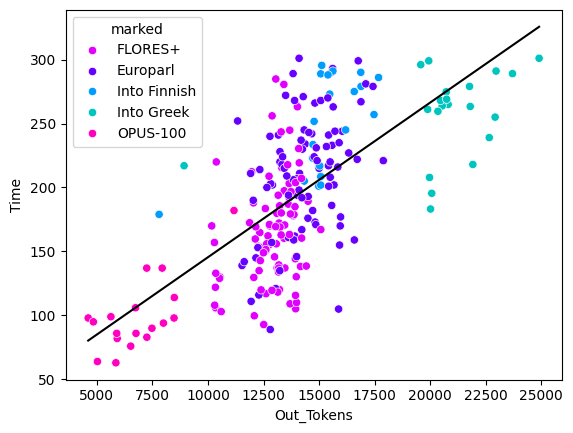

In [37]:
from scripts.presentation import correlations, linear_regression
config1 = {
    'datasets': ['ep', 'flores', 'opus'],
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Out_Tokens'
}
config2 = {
    'datasets': ['ep', 'flores', 'opus'],
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Time'
}
correlations(df, config1, config2, show=True)
labels = {'EP': 'Europarl', 'FLORES': 'FLORES+', 'OPUS': 'OPUS-100'}
colors = {'ep': '#6600FF', 'flores': '#E100FF', 'opus': '#FF00C0'}

focus_colors = {'fi': "#009DFF", 'el': "#00C5BE"}

custom_color = {'tgt_lang': focus_colors, 'dataset': colors}
label_map = labels

data, model = linear_regression(df, config1, config2, 'Out_Tokens', 'Time', plot=True, custom_color=custom_color, label_map=label_map)

In [38]:
df_opus = data[data['dataset'] == 'opus']
df_ep = data[data['dataset'] == 'ep']
df_flores = data[data['dataset'] == 'flores']
print(f'EP Avg. Tokens: {df_ep["score_x"].mean():.2f}')
print(f'Opus Avg. Tokens: {df_opus["score_x"].mean():.2f}')
print(f'Flores Avg. Tokens: {df_flores["score_x"].mean():.2f}')

EP Avg. Tokens: 15283.40
Opus Avg. Tokens: 7026.00
Flores Avg. Tokens: 13747.45


In [39]:
src2time = {}
for src_lang in data['src_lang'].unique():
    src2time[src_lang] = data[data['src_lang'] == src_lang]['score_y'].mean()

tgt2time = {}
for tgt_lang in data['tgt_lang'].unique():
    tgt2time[tgt_lang] = data[data['tgt_lang'] == tgt_lang]['score_y'].mean()

for k, v in sorted(src2time.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v:.2f}')

el: 213.58
fr: 207.07
fi: 205.46
nl: 202.72
pt: 201.80
it: 196.48
de: 186.67
es: 186.26
da: 184.25
sv: 180.11
en: 165.13


In [40]:
for k, v in sorted(tgt2time.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v:.2f}')

el: 256.90
fi: 247.87
de: 208.05
da: 205.14
fr: 194.92
sv: 192.91
nl: 192.83
it: 187.44
pt: 170.90
es: 162.32
en: 126.73


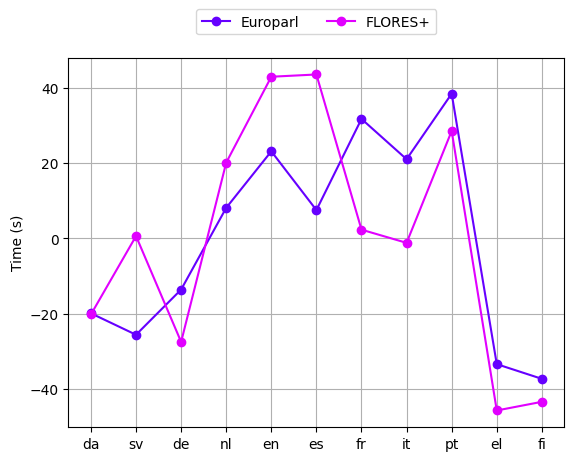

In [41]:
from scripts.presentation import aggregate_matrices, plot_vectors, form_matrices, matrix_merger
import matplotlib.pyplot as plt
matrices = form_matrices(df, 'Time', ['gpt', 'gpt'], ['ep', 'flores'])
merged = matrix_merger(matrices, 'dataset')
agg = aggregate_matrices(merged, mode='DIFF', include_base=False)
def legend():
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
labels = {'ep': 'Europarl', 'flores': 'FLORES+'}
plot_vectors(agg, include_base=False, ylabel='Time (s)', label_map=labels, color_map=colors, legend=legend)


Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : Time
Pearson correlation: -0.43 (p = 3.7e-12)
Spearman correlation: -0.44 (p = 1.2e-12)


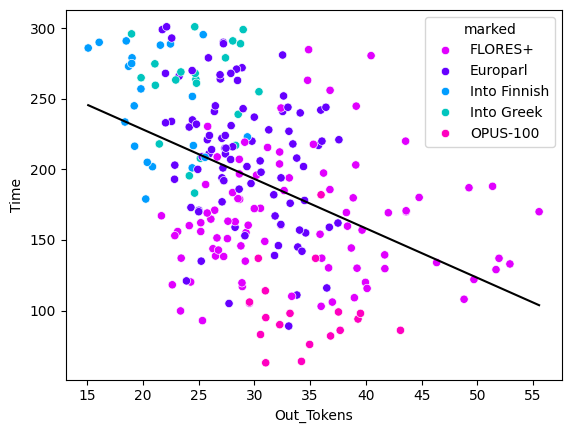

In [16]:
from scripts.presentation import correlations, linear_regression
config1 = {
    'datasets': ['ep', 'flores', 'opus'],
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'BLEU'
}
config2 = {
    'datasets': ['ep', 'flores', 'opus'],
    'translators': ['gpt'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Time'
}
correlations(df, config1, config2, show=True)
labels = {'EP': 'Europarl', 'FLORES': 'FLORES+', 'OPUS': 'OPUS-100'}
colors = {'ep': '#6600FF', 'flores': '#E100FF', 'opus': '#FF00C0'}

focus_colors = {'fi': "#009DFF", 'el': "#00C5BE"}

custom_color = {'tgt_lang': focus_colors, 'dataset': colors}
label_map = labels

data, model = linear_regression(df, config1, config2, 'Out_Tokens',
                                'Time', plot=True, custom_color=custom_color, label_map=label_map)

## Time Analysis (DeepL)

Datasets: ['ep', 'flores', 'opus'] : ['ep', 'flores', 'opus']
Translators: ['deepl'] : ['deepl']
Metric: Out_Tokens : Time
Pearson correlation: 0.39 (p = 6.5e-10)
Spearman correlation: 0.48 (p = 1.7e-15)


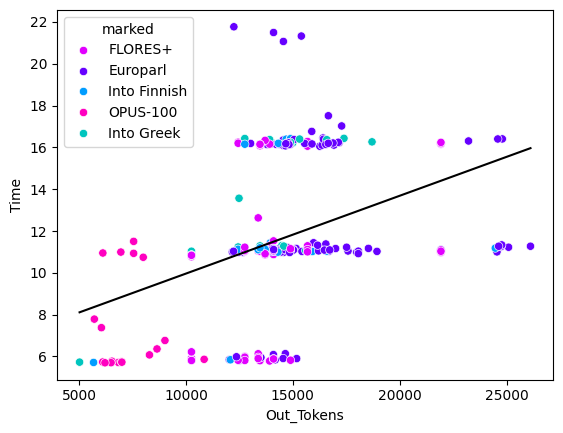

In [17]:
from scripts.presentation import correlations, linear_regression
config1 = {
    'datasets': ['ep', 'flores', 'opus'],
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Out_Tokens'
}
config2 = {
    'datasets': ['ep', 'flores', 'opus'],
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'Time'
}
correlations(df, config1, config2, show=True)
labels = {'EP': 'Europarl', 'FLORES': 'FLORES+', 'OPUS': 'OPUS-100'}
colors = {'ep': '#6600FF', 'flores': '#E100FF', 'opus': '#FF00C0'}

focus_colors = {'fi': "#009DFF", 'el': "#00C5BE"}

custom_color = {'tgt_lang': focus_colors, 'dataset': colors}
label_map = labels

data, model = linear_regression(df, config1, config2, 'Out_Tokens',
                                'Time', plot=True, custom_color=custom_color, label_map=label_map)

In [18]:
!cat proc1.log | grep -P -A10 'DeepL API response' | head -n 8 | tail -n 1

INFO: 2025-05-07 14:57:37 - Rechecking document translation status after sleeping for 5.000 seconds. 


In [19]:
data.sort_values(by='score_y', ascending=False)[
    ['src_lang', 'tgt_lang', 'score_y']].head(5)

,src_lang,tgt_lang,score_y
161,en,nl,21.768036
144,de,es,21.494549
206,pt,it,21.324425
23,pt,en,21.065953
199,sv,pt,17.511968


In [20]:
buckets = {k: [] for k in [6, 11, 16, 22]}

for _, row in data.iterrows():
    dist = {k: abs(row['score_y'] - k) for k in buckets}
    min_key = min(dist, key=dist.get)
    buckets[min_key].append(row)

buckets = {k: pd.DataFrame(rows) for k, rows in buckets.items()}

In [21]:
for k, v in buckets.items():
    avg_score = v['score_y'].mean()
    print(f'{k}: {avg_score:.2f}')

6: 5.99
11: 11.11
16: 16.23
22: 21.41


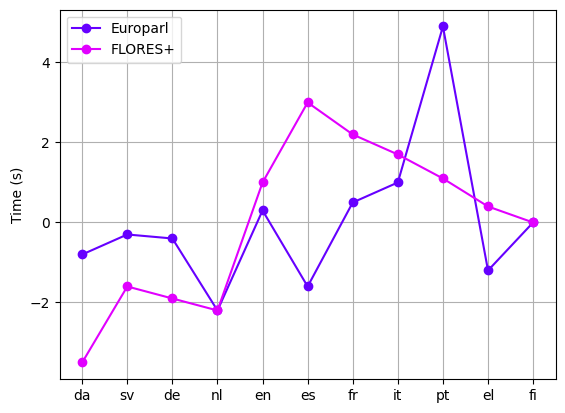

In [22]:
from scripts.presentation import aggregate_matrices, plot_vectors, form_matrices, matrix_merger
matrices = form_matrices(df, 'Time', ['deepl', 'deepl'], ['ep',  'flores'])
merged = matrix_merger(matrices, 'dataset')
agg = aggregate_matrices(merged, mode='DIFF', include_base=False)
labels = {'ep': 'Europarl', 'flores': 'FLORES+'}
plot_vectors(agg, include_base=False, ylabel='Time (s)',
             label_map=labels, color_map=colors)

# Cost

In [23]:
df.head(3)

,BLEU,chrF,BERT-F1,dataset,translator,src_lang,tgt_lang,COMET,Time,Out_Tokens,In_Tokens,Chars
0,54.799530,75.295543,93.870700,flores,deepl,da,en,91.044375,10.874540,14097,10227,50961
1,33.634741,60.229124,89.559616,flores,deepl,fr,pt,88.003590,11.132139,13914,12544,58255
2,28.786491,57.433125,86.359790,flores,gpt,nl,de,86.766763,145.805712,12997,12808,55471


In [24]:
import numpy as np
def gpt_cost(input_tokens, output_tokens):
    return (input_tokens / 1_000_000) *2.00 + (output_tokens / 1_000_000) * 8.00


def deepl_cost(input_chars):
    return 2e-5 * input_chars


df['Cost'] = np.where(
    df['translator'] == 'deepl',
    deepl_cost(df['Chars']),
    gpt_cost(df['In_Tokens'], df['Out_Tokens'])
)

In [25]:
subset = df[df['translator'] == 'deepl']
subset['Cost'].sum()


278.36272

In [26]:
subset = df[df['translator'] == 'gpt']
subset['Cost'].sum()

33.634932000000006